## Import Library

In [86]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Activation
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
import tqdm
import imgaug.augmenters as iaa
import joblib
warnings.filterwarnings('ignore')

In [87]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [88]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Load, Color Conversion, Resize, Labelling

In [89]:
df_path=pd.read_csv('data/train_data.csv')

images_path='data/Train/'

df_path.columns=['filepaths', 'labels' ]
df_path['filepaths']=df_path['filepaths'].apply(lambda x: os.path.join(images_path,x))
df_path.head()

,filepaths,labels
0,data/Train/salmo.1558.jpg,Salmonella
1,data/Train/cocci.1866.jpg,Coccidiosis
2,data/Train/cocci.171.jpg,Coccidiosis
3,data/Train/salmo.1484.jpg,Salmonella
4,data/Train/ncd.100.jpg,New Castle Disease


In [90]:
Size = 128
images = []
labels = []

for idx, row in df_path.iterrows():
    # Baca data gambar dan ubah ke RGB
    image = cv2.imread(row['filepaths'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize gambar ke ukuran yang diinginkan
    image = cv2.resize(image, (Size, Size))

    # Masukkan hasil resize dan label
    images.append(image)
    labels.append(row['labels'])

images = np.array(images)
labels = np.array(labels)


## Melihat Data

In [91]:
# melihat shape data
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (8067, 128, 128, 3)
Labels Shape : (8067,)


In [92]:
lab = pd.DataFrame({'labels':labels})
lab.value_counts()

labels            
Salmonella            2625
Coccidiosis           2476
Healthy               2404
New Castle Disease     562
dtype: int64

<Axes: title={'center': 'Jumlah Data Berdasarkan Kelas'}, ylabel='count'>

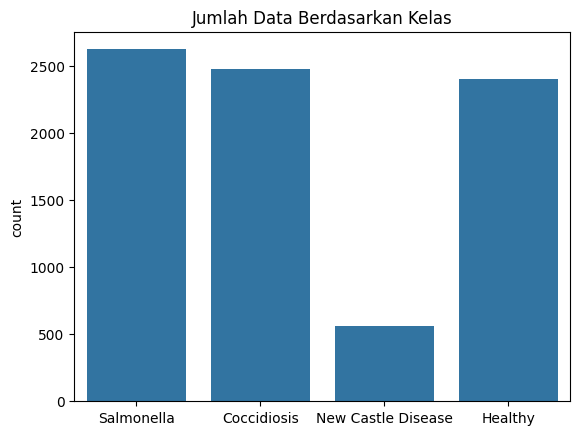

In [93]:
plt.title('Jumlah Data Berdasarkan Kelas')
sns.countplot(x=labels)

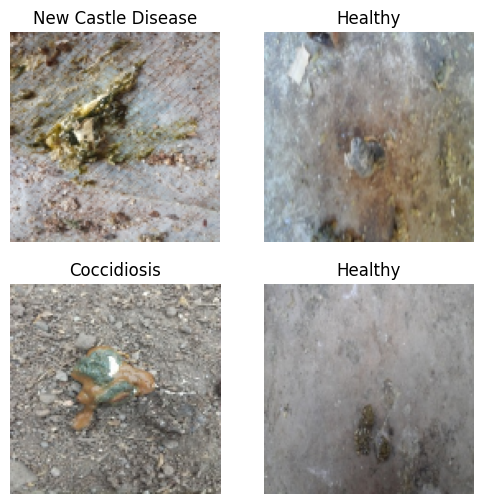

In [94]:
# menampilkan data
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images),4):
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')    
    x += 1

## Augmentasi Data

In [95]:
# augmentasi data
aug = iaa.Sequential([
    iaa.Fliplr(),  # Flip 
    iaa.Affine(rotate=(-30, 30)),  # Rotasi -30 - 30 degree
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Blur antara 0 - 1
    iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)), # Noise dengan prob. 50%
    iaa.Multiply((0.5, 1.5)) # mencerahkan * antara 0.5-1.5
])

# jumlah augmentasi
num_augmented_images = 4

augmented_images = []
augmented_labels = []

# label yang diaugmentasi
target_label = 'New Castle Disease'

for i in range(len(images)):
    current_image = images[i]
    current_label = labels[i]

    augmented_images.append(current_image)
    augmented_labels.append(current_label)

    # Lakukan augmentasi hanya untuk label tertentu
    if current_label == target_label:
        for _ in range(num_augmented_images):
            augmented = aug(images=[current_image])[0]  
            augmented_images.append(augmented)
            augmented_labels.append(current_label)

images = np.array(augmented_images)
labels = np.array(augmented_labels)


In [96]:
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (10315, 128, 128, 3)
Labels Shape : (10315,)


In [97]:
lab = pd.DataFrame({'labels':labels})
lab.value_counts()

labels            
New Castle Disease    2810
Salmonella            2625
Coccidiosis           2476
Healthy               2404
dtype: int64

<Axes: title={'center': 'Jumlah Data Berdasarkan Kelas'}, ylabel='count'>

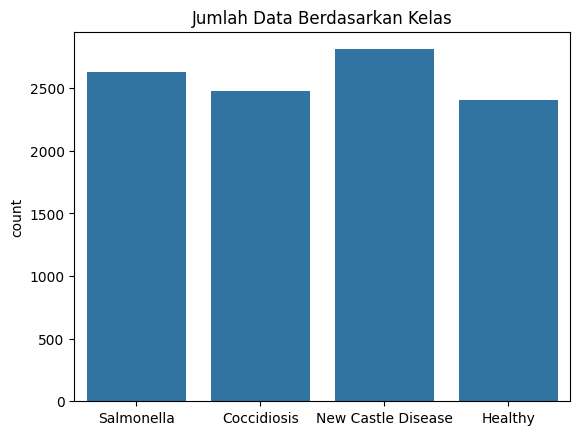

In [98]:
plt.title('Jumlah Data Berdasarkan Kelas')
sns.countplot(x=labels)

## Hasil Augmentasi

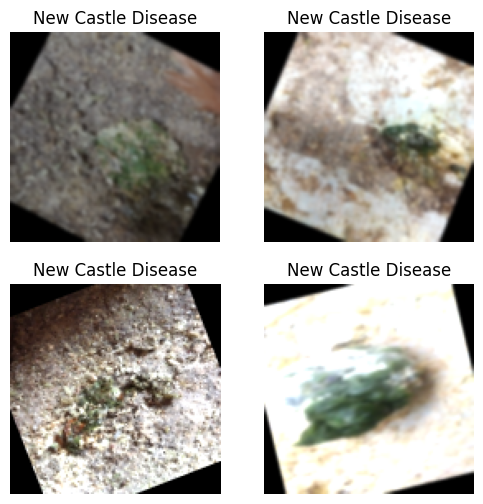

In [99]:
# Melihat hasil augmentasi
target = [i for i in range(len(images)) if labels[i] == target_label]

plt.figure(figsize=(6, 6))
x = 1
selected_indices = np.random.choice(target, 4, replace=False)
for i in selected_indices:
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

plt.show()


In [100]:
# label encoding
le=LabelEncoder()
labels=le.fit_transform(labels)

joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

In [101]:
# splitting data menjadi train, test, val
# menerapkan shuffle dan stratify untuk mencegah homogenitas data dan data imbalance pada test
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=1, shuffle=True, stratify=labels) 
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=1, shuffle =True, stratify=y_test)


In [16]:
base_dir = "data_test"
os.makedirs(base_dir, exist_ok=True)
for i in range(len(x_test)):
    label = le.inverse_transform([y_test[i]])[0]

    # menentukan path berdasarkan label
    label_dir = os.path.join(base_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # menyimpan gambar berdasarkan path sebelumnya
    file_path = os.path.join(label_dir, f"gambar_{i}.png")
    plt.imsave(file_path, x_test[i], format="png", cmap="gray")

# Modelling

In [35]:
model = Sequential()

model.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same'))
model.add(Conv2D(32, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, (3,3), 1, activation='relu', padding='same', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(256, (3,3), 1, activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), 1, activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4, activation='softmax'))

In [36]:
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics='accuracy')
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val,y_val), callbacks=[checkpoint, earlystop], batch_size=512)

Epoch 1/30
17/17 [==============================] - 4s 164ms/step - loss: 1.3049 - accuracy: 0.4087 - val_loss: 1.1651 - val_accuracy: 0.5044
Epoch 2/30
17/17 [==============================] - 3s 150ms/step - loss: 0.8335 - accuracy: 0.7219 - val_loss: 1.4878 - val_accuracy: 0.5112
Epoch 3/30
17/17 [==============================] - 3s 151ms/step - loss: 0.7224 - accuracy: 0.7447 - val_loss: 0.8267 - val_accuracy: 0.6411
Epoch 4/30
17/17 [==============================] - 3s 155ms/step - loss: 0.6590 - accuracy: 0.7575 - val_loss: 0.7828 - val_accuracy: 0.7003
Epoch 5/30
17/17 [==============================] - 3s 154ms/step - loss: 0.5487 - accuracy: 0.8232 - val_loss: 0.6825 - val_accuracy: 0.7565
Epoch 6/30
17/17 [==============================] - 3s 159ms/step - loss: 0.5031 - accuracy: 0.8339 - val_loss: 0.6774 - val_accuracy: 0.7837
Epoch 7/30
17/17 [==============================] - 3s 159ms/step - loss: 0.4624 - accuracy: 0.8485 - val_loss: 0.6745 - val_accuracy: 0.7837
Epoch 

## Plot Training

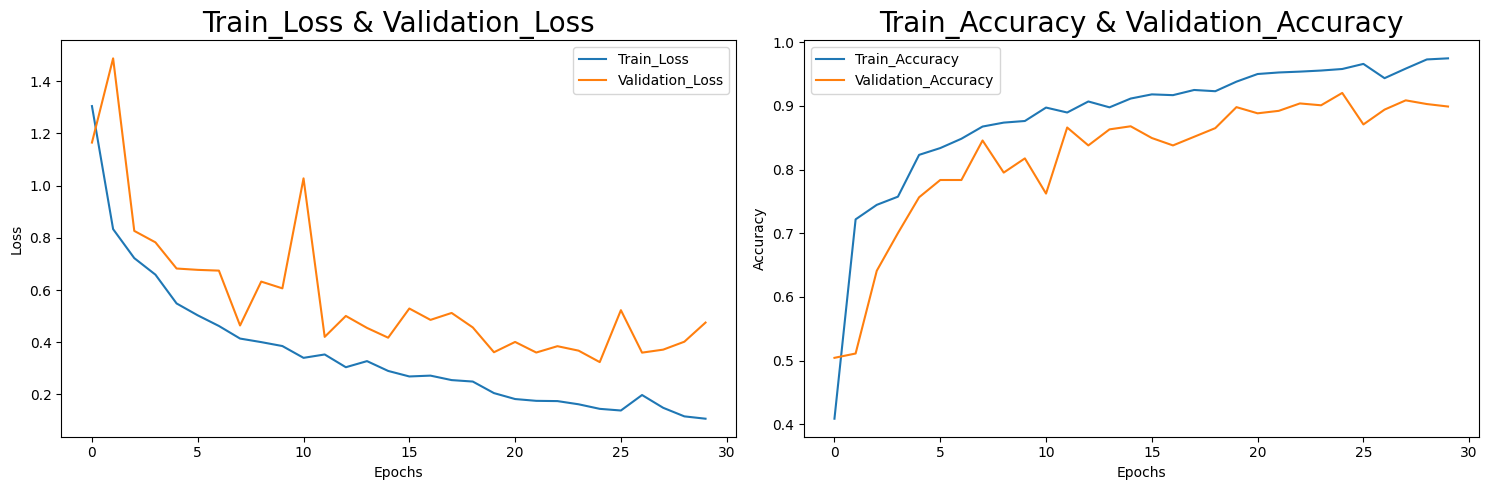

In [37]:
hist_=pd.DataFrame(hist.history) # memasukkan history ke dataframe agar dapat di plotting
plt.figure(figsize=(15, 5))

# Subplot 1 - Loss
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Subplot 2 - Accuracy
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  
plt.show()


## Test Accuracy

In [102]:
model = load_model('best_model.h5')

In [103]:
score, acc = model.evaluate(x_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

33/33 [==============================] - 1s 13ms/step - loss: 0.3732 - accuracy: 0.9147
Test Loss = 0.37323659658432007
Test Accuracy = 0.9147287011146545


## Predict X test

In [104]:
# memprediksi x_test dan memasukkannya ke dataframe
prediction = model.predict(x_test)
y_pred=np.argmax(prediction, axis=1)
df=pd.DataFrame()
df['Actual'],df['Prediction']=le.inverse_transform(y_test),le.inverse_transform(y_pred)
df

33/33 [==============================] - 0s 6ms/step


,Actual,Prediction
0,Healthy,Healthy
1,Salmonella,Salmonella
2,New Castle Disease,New Castle Disease
3,Coccidiosis,Healthy
4,Coccidiosis,Coccidiosis
...,...,...
1027,Coccidiosis,Coccidiosis
1028,Coccidiosis,Coccidiosis
1029,Coccidiosis,Coccidiosis
1030,New Castle Disease,Healthy


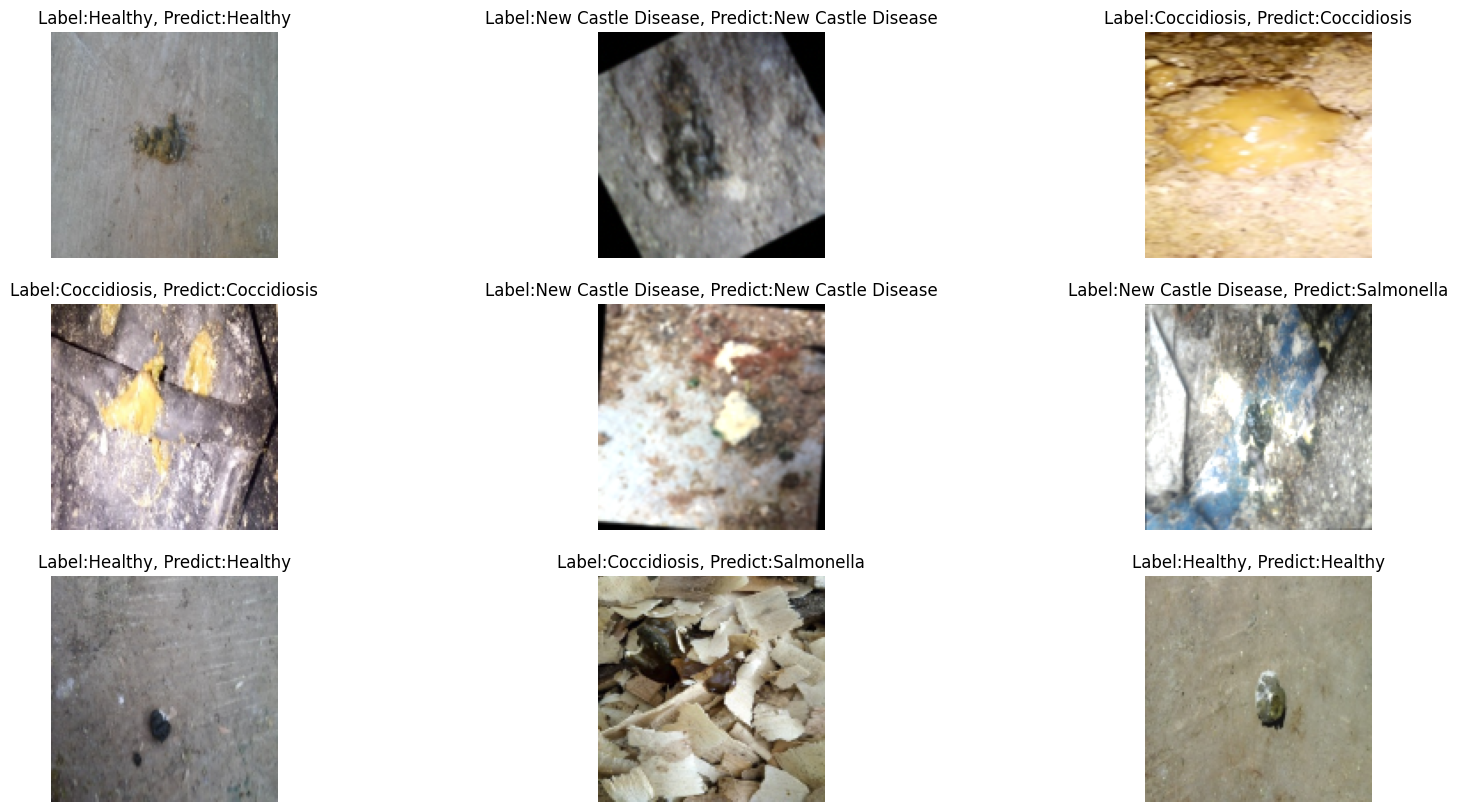

In [105]:
# melihat hasil perbandingkan label dan prediksi
y_test2=le.inverse_transform(y_test)
y_pred2=le.inverse_transform(y_pred)
plt.figure(figsize=(20,10))
x = 1
for i in np.random.randint(0,len(x_test),9):
    plt.subplot(3, 3, x)
    plt.imshow(x_test[i])
    plt.title(f'Label:{y_test2[i]}, Predict:{y_pred2[i]}', fontsize=12)
    plt.axis('off')    
    x += 1

## Confusion Matrix

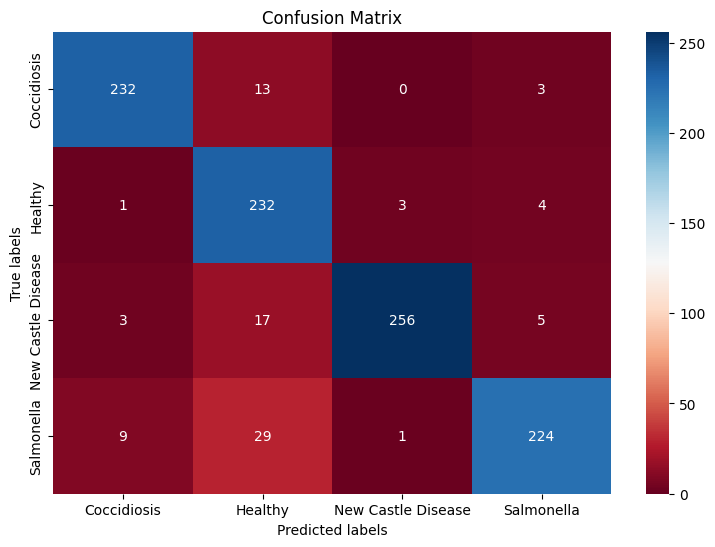

In [106]:
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

CM = confusion_matrix(y_test_original, y_pred_original)

class_labels = le.classes_

plt.figure(figsize=(9, 6))
sns.heatmap(CM, annot=True, fmt='g', cmap='RdBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


## Classification Report

In [107]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       248
           1       0.80      0.97      0.87       240
           2       0.98      0.91      0.95       281
           3       0.95      0.85      0.90       263

    accuracy                           0.91      1032
   macro avg       0.92      0.92      0.91      1032
weighted avg       0.92      0.91      0.92      1032

